In this notebook we determine reasonable values for parameters that were not measured directly in previous studies.

# Place-tuned synaptic weights
### Result: W_A_PL_CA3 = 0.017

We choose a synaptic weight for place-tuned inputs onto CA3 PCs that yields an EPSP with a peak magnitude of approximately 4 mV, as measured by Hyun et al., (2015).

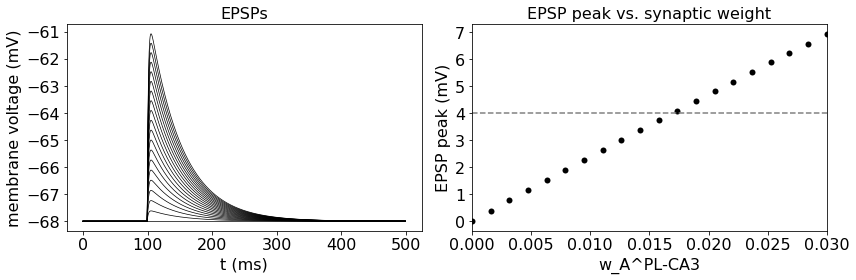

In [28]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size

WS_AMPA = np.linspace(0, .03, 20)

# single unit parameters
T_M = 0.05  # (s)
V_RESET = -0.068  # (V)
E_LEAK = -0.068  # (V)
V_TH = -0.036  # (V)
T_R = 0.002  # (s)
ES_REV = {'AMPA': 0}
TS_SYN = {'AMPA': 0.002}
WS_RCR = {'AMPA': np.array([[0.]])}

# simulation parameters
DUR = 0.5  # (s)
DT = 0.0005  # (s)
INPUT_TIME = 0.1  # (s)

# upstream AMPA drive
ts = np.arange(0, DUR, DT)
spks_up = np.zeros((len(ts), 1))

# add a single upstream spiking input at INPUT_TIME
spks_up[int(INPUT_TIME/DT)] = 1

# loop over upstream ampa weights
fig, axs = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
vs_init = np.array([E_LEAK])
gs_init = {'AMPA': np.array([0.])}

epsp_peaks = np.nan * np.zeros(WS_AMPA.shape)

for ctr, w_ampa in enumerate(WS_AMPA):
    # make upstream weight matrix
    ws_up = {'AMPA': np.array([[w_ampa]])}
    
    # make ntwk
    ntwk = LIFNtwk(
        tau_m=T_M, e_leak=E_LEAK, v_th=V_TH, v_reset=V_RESET, tau_r=T_R,
        es_rev=ES_REV, taus_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
    
    # run simulation
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=DT)
    
    # plot 
    axs[0].plot(1000 * ts, 1000 * resp.vs, color='k', lw=0.7)
    
    epsp_peaks[ctr] = resp.vs.max() - resp.vs.min()

axs[0].set_xlabel('t (ms)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('EPSPs')

axs[1].scatter(WS_AMPA, 1000 * epsp_peaks, c='k', lw=0)
axs[1].axhline(4, color='gray', ls='--')
axs[1].set_xlim(WS_AMPA[0], WS_AMPA[-1])
axs[1].set_xlabel('w_A^PL-CA3')
axs[1].set_ylabel('EPSP peak (mV)')
axs[1].set_title('EPSP peak vs. synaptic weight')

for ax in axs:
    set_font_size(ax, 16)

The above results suggest we should use an AMPA weight of about 0.017 for place-tuned inputs onto CA3 pyramidal cells.

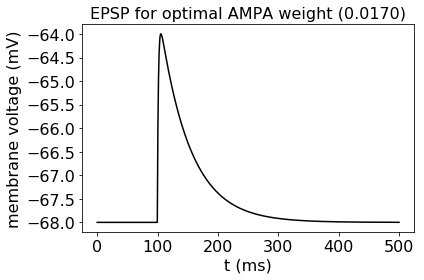

In [29]:
# show an EPSP from a place-tuned input with this AMPA weight
W_AMPA = 0.017
ws_up = {'AMPA': np.array([[W_AMPA]])}

# make and run ntwk
ntwk = LIFNtwk(
    tau_m=T_M, e_leak=E_LEAK, v_th=V_TH, v_reset=V_RESET, tau_r=T_R,
    es_rev=ES_REV, taus_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=ws_up)
resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=DT)

# make plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), tight_layout=True)
ax.plot(1000 * ts, 1000 * resp.vs, color='k')
ax.set_xlabel('t (ms)')
ax.set_ylabel('membrane voltage (mV)')
ax.set_title('EPSP for optimal AMPA weight ({0:.4f})'.format(W_AMPA))
set_font_size(ax, 16)

# Maximum place-tuned synaptic input rate
### Result: R_MAX_PL = 350 Hz

We choose this value such that the CA3 output firing rate is approximately 20 Hz when the maximum place-tuned synaptic input is presented to the neuron.

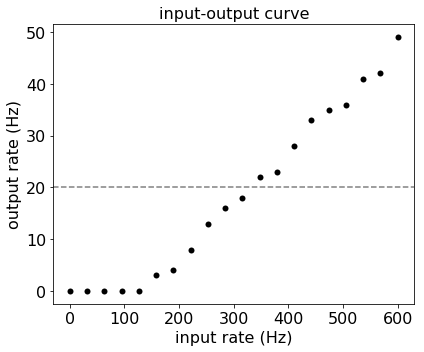

In [36]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from ntwk import LIFNtwk
from plot import set_font_size
from sim import upstream_spikes_from_positions

MAX_RATES_UP = np.linspace(0, 600, 20)

# single unit parameters
T_M = 0.05  # (s)
V_RESET = -0.068  # (V)
E_LEAK = -0.068  # (V)
V_TH = -0.036  # (V)
T_R = 0.002  # (s)
ES_REV = {'AMPA': 0}
TS_SYN = {'AMPA': 0.002}
WS_RCR = {'AMPA': np.array([[0.]])}
WS_UP = {'AMPA': np.array([[0.017]])}

# simulation parameters
DUR = 3  # (s)
DT = 0.0005  # (s)
SEED = 0
SPK_RATE_ITVL = (2, 3)

# make ntwk
ntwk = LIFNtwk(
    tau_m=T_M, e_leak=E_LEAK, v_th=V_TH, v_reset=V_RESET, tau_r=T_R,
    es_rev=ES_REV, taus_syn=TS_SYN, ws_rcr=WS_RCR, ws_up=WS_UP)

# loop over max synaptic input rate values
ts = np.arange(0, DUR, DT)
xys = np.zeros((len(ts), 2))
centers = np.zeros((2, 1))
stds = np.array([0.1])

spk_rate_itvl_mask = ((ts >= SPK_RATE_ITVL[0]) * (ts < SPK_RATE_ITVL[1])).astype(bool)

vs_init = np.array([E_LEAK])
gs_init = {'AMPA': np.array([0.])}

np.random.seed(SEED)

fig, ax = plt.subplots(1, 1, figsize=(6, 5), tight_layout=True)

spk_rates_out = np.nan * np.zeros(MAX_RATES_UP.shape)

for ctr, max_rate_up in enumerate(MAX_RATES_UP):
    
    # get upstream spikes and run ntwk
    max_rates = np.array([max_rate_up])
    spks_up = upstream_spikes_from_positions(ts, xys, centers, stds, max_rates)
    resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=DT)
    
    # calculate spike rate
    itvl = SPK_RATE_ITVL[1] - SPK_RATE_ITVL[0]
    spk_rates_out[ctr] = resp.spks[spk_rate_itvl_mask].sum() / itvl

# plot output spk rate vs. input rate
ax.scatter(MAX_RATES_UP, spk_rates_out, color='k', lw=0)
ax.axhline(20, color='gray', ls='--')
ax.set_xlabel('input rate (Hz)')
ax.set_ylabel('output rate (Hz)')
ax.set_title('input-output curve')

set_font_size(ax, 16)

These results suggest that an input rate of about 350 Hz will yield an output firing rate of about 20 Hz.

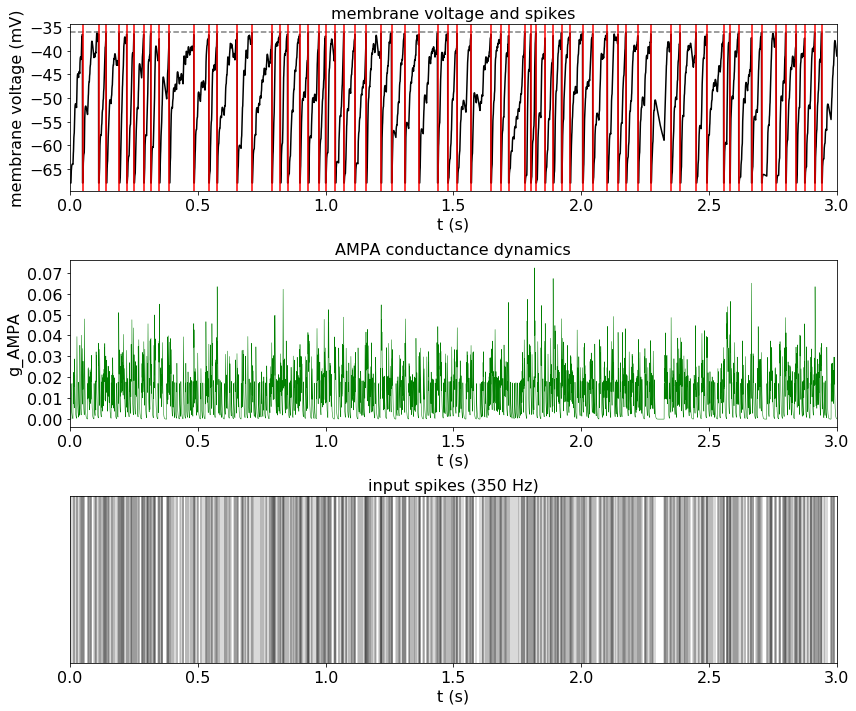

In [41]:
# show the membrane potential dynamics given this input rate
MAX_RATE_UP = 350

max_rates = np.array([MAX_RATE_UP])
spks_up = upstream_spikes_from_positions(ts, xys, centers, stds, max_rates)

resp = ntwk.run(spks_up=spks_up, vs_init=vs_init, gs_init=gs_init, dt=DT)

# plot voltage, spiking response, AMPA conductance, and input spikes
fig, axs = plt.subplots(3, 1, figsize=(12, 10), tight_layout=True)

# voltage
axs[0].plot(ts, 1000 * resp.vs, color='k')
axs[0].axhline(1000 * V_TH, color='gray', ls='--')

# spikes
for spk_idx in resp.spks.nonzero()[0]:
    axs[0].axvline(spk_idx*DT, color='r')

axs[0].set_xlabel('t (s)')
axs[0].set_ylabel('membrane voltage (mV)')
axs[0].set_title('membrane voltage and spikes')

# AMPA conductance
axs[1].plot(ts, resp.gs['AMPA'], color='g', lw=0.5)

axs[1].set_xlabel('t (s)')
axs[1].set_ylabel('g_AMPA')
axs[1].set_title('AMPA conductance dynamics')

# input spikes
for spk_idx in spks_up.nonzero()[0]:
    axs[2].axvline(spk_idx*DT, color='k', lw=.3)
    
axs[2].yaxis.set_visible(False)
axs[2].set_xlabel('t (s)')
axs[2].set_title('input spikes ({} Hz)'.format(MAX_RATE_UP))

for ax in axs:
    ax.set_xlim(ts[0], ts[-1])
    set_font_size(ax, 16)

# EC-CA3 initial and final synaptic weights

We choose synaptic weights to yield initial and final EPSP sizes of approximately 2 mV and 4 mV, respectively, as determined by Hyun, et al., (2013, 2015).

# EC-CA3 activity-dependent plasticity

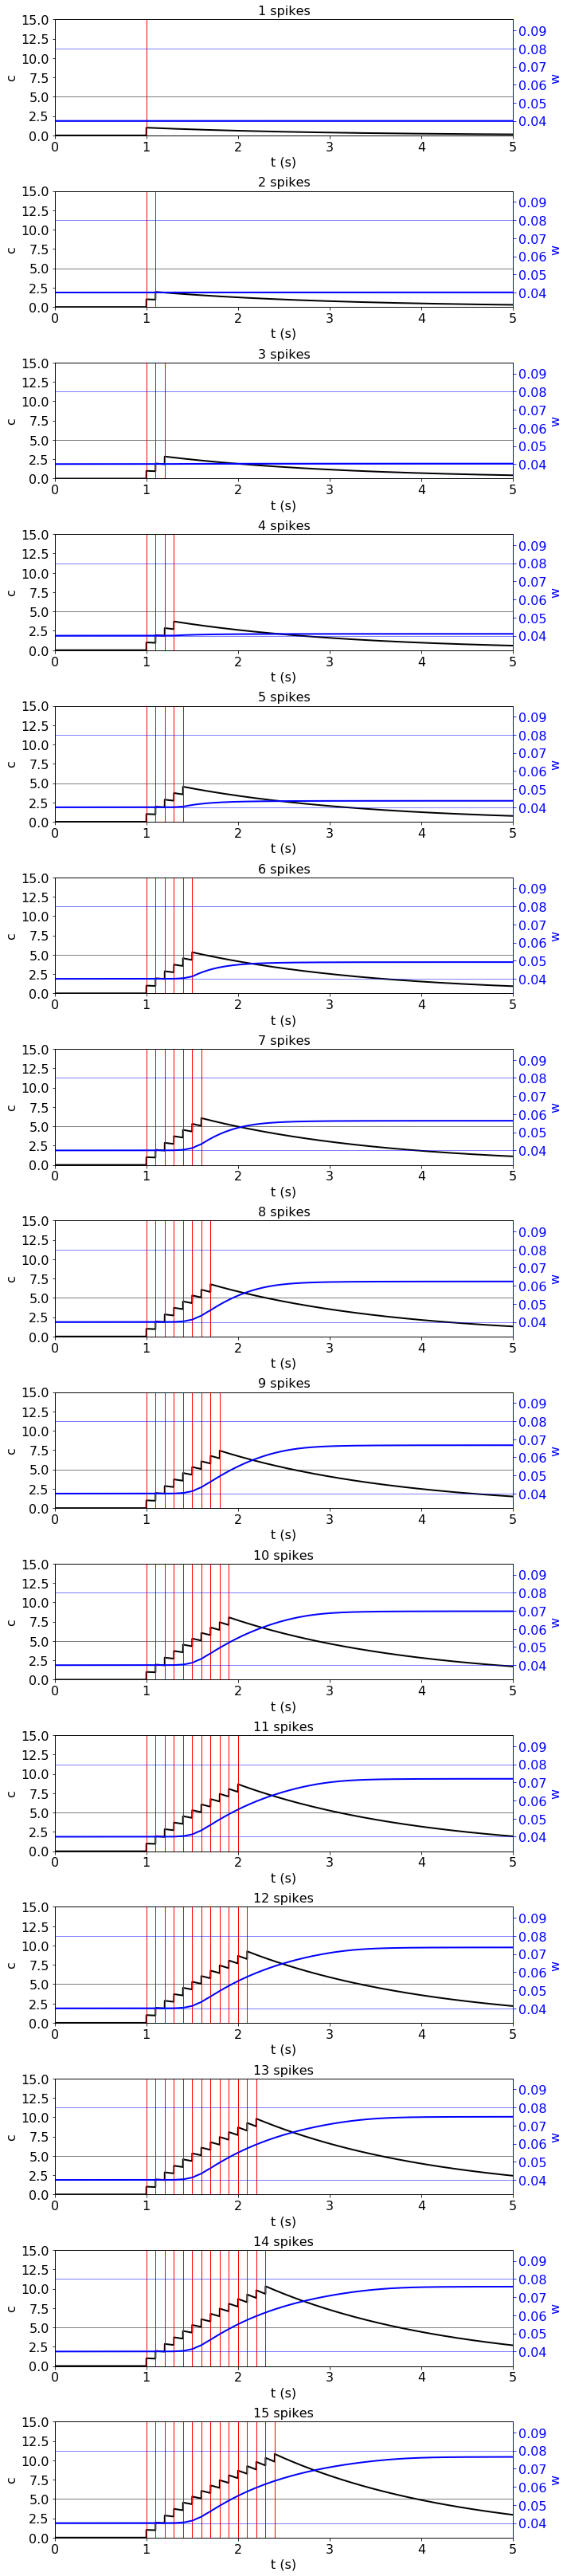

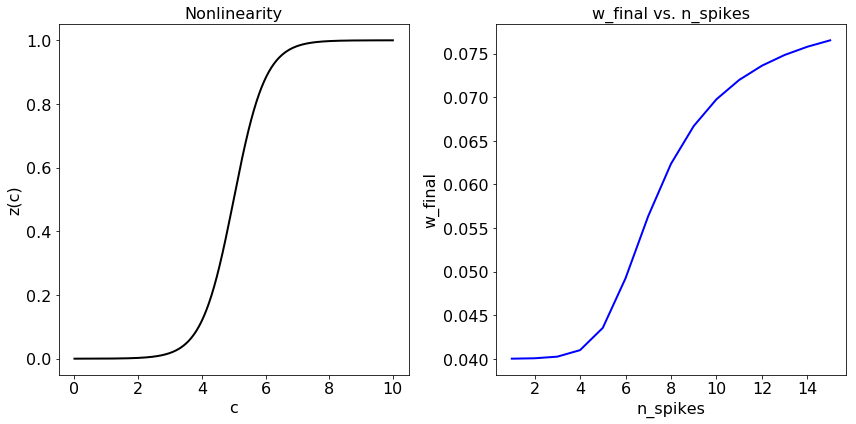

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from plot import set_font_size

DT = 0.0005  # numerical integration time step (s)
FIRST_SPIKE_TIME = 1  # time of first spike (s)
DUR = 5  # simulation duration (s)

F = 10  # freq (Hz)
T_W = 1  # weight change timescale (s)
W_MIN = 0.04  # min weight
W_MAX = 0.08  # max weight

T_C = 2  # spike-counting timescale (s)
C_S = 5  # spike-counting soft threshold
BETA_C = 0.5  # spike-counting nonlinearity slope

MAX_SPIKES = 15


def z(c):
    return 1 / (1 + np.exp(-(c - C_S)/BETA_C))

fig, axs = plt.subplots(
    MAX_SPIKES, 1, figsize=(10, 3*MAX_SPIKES), tight_layout=True, squeeze=False)

n_spikes_all = range(1, MAX_SPIKES+1)
w_finals = []

for plt_ctr, n_spikes in enumerate(n_spikes_all):
    
    # initialize structures for storing spike-counter and synaptic weight
    ts = np.arange(0, DUR, DT)
    cs = np.nan * np.zeros(ts.shape)
    ws = np.nan * np.zeros(ts.shape)
    
    cs[0] = 0
    ws[0] = W_MIN
    
    # make spike train
    spikes = np.zeros(ts.shape)
    t_spikes = FIRST_SPIKE_TIME + np.arange(n_spikes) / F
    
    for t_spike in t_spikes:
        spikes[int(t_spike/DT)] = 1
        
    # run simulation
    for step in range(1, len(ts)):
        
        # update spike counter
        dc = -cs[step-1] * DT / T_C + spikes[step]
        cs[step] = cs[step-1] + dc
        
        # update synaptic weight
        dw = z(cs[step]) * (W_MAX - ws[step-1]) * DT / T_W
        ws[step] = ws[step-1] + dw
        
    # store final w
    w_finals.append(ws[-1])
        
    # make plots
    ax_c = axs[plt_ctr, 0]
    ax_w = ax_c.twinx()
    
    for t_spike in t_spikes:
        ax_c.axvline(t_spike, color='r', lw=1)
        ax_w.axvline(t_spike, color='r', lw=1)
        
    # spike-counter
    ax_c.plot(ts, cs, color='k', lw=2)
    ax_c.axhline(C_S, color='k', lw=0.5)
    
    ax_c.set_xlim(ts[0], ts[-1])
    ax_c.set_ylim(0, MAX_SPIKES)
    
    ax_c.set_xlabel('t (s)')
    ax_c.set_ylabel('c')
    ax_c.set_title('{} spikes'.format(n_spikes))
    
    # synaptic weight
    ax_w.plot(ts, ws, color='b', lw=2)
    ax_w.axhline(W_MIN, color='b', lw=0.5)
    ax_w.axhline(W_MAX, color='b', lw=0.5)
    
    ax_w.set_xlim(ts[0], ts[-1])
    ax_w.set_ylim(0.8*W_MIN, 1.2*W_MAX)
    
    ax_w.set_ylabel('w', color='b')
    ax_w.spines['right'].set_color('b')
    ax_w.tick_params(axis='y', colors='b')
    
    set_font_size(ax_c, 16)
    set_font_size(ax_w, 16)
    
# plot z(c) and w_final vs. n_spikes
fig, axs = plt.subplots(1, 2, figsize=(12, 6), tight_layout=True)

# z(c) vs. c
cs = np.linspace(0, 10, 500)
axs[0].plot(cs, z(cs), color='k', lw=2)
axs[0].set_xlabel('c')
axs[0].set_ylabel('z(c)')
axs[0].set_title('Nonlinearity')

# w_final vs. n_spikes
axs[1].plot(n_spikes_all, w_finals, color='b', lw=2)
axs[1].set_xlabel('n_spikes')
axs[1].set_ylabel('w_final')
axs[1].set_title('w_final vs. n_spikes')

for ax in axs:
    set_font_size(ax, 16)